In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.font_manager import FontProperties
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy import interpolate

import warnings

In [2]:
warnings.filterwarnings('ignore')

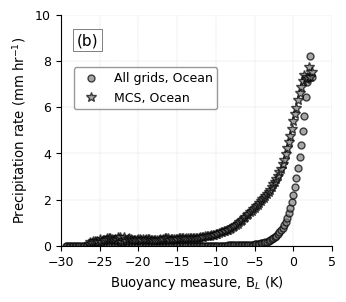

In [3]:
### 1. buoyancy-precip 1-D: all grids, MCS grids, non-MCS grids 

### get B-P data of all grids ####
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats')
data_all = xr.open_dataset(out_dir / 'buoy_precipitation_multiregions.2002.2014.nc')

### get B-P data of MCSs
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/BLtot_precip_hist/')
year_list = np.arange(2002,2021)

for n,year in enumerate(year_list):
    data = xr.open_dataset(out_dir / 'hist1d_BL_dtype.{}.ocean.3deg.alltracks.nc'.format(year))
    tmp = data.sum(('tracks','duration_type')).sel(bins_tot=slice(-29.75,10))
    
    if n == 0: 
        data_all_ocean = tmp
    else:
        data_all_ocean += tmp


###### plotting #######

fig,ax = plt.subplots(1,1,figsize=(3.5,3))

# for all grids (using a subsat)
samples = data_all.samples.sel(region=['IND','EPC','ATL']).sum('region')
prec_sum = data_all.prec_gpm_sum.sel(region=['IND','EPC','ATL']).sum('region')
cond_prec = prec_sum/samples
# masking out under-sampled values
cond_prec = cond_prec.where(samples > 200)

ax.plot(data_all.BL_bins, cond_prec, 'o', color='grey', markeredgecolor='k', ls='None', ms=5, 
        alpha=0.7)
ax.set_ylabel('Precipitation rate (mm hr$^{-1}$)',fontsize=9.5)
ax.set_xlabel('Buoyancy measure, B$_{L}$ (K)',fontsize=9.5)
ax.tick_params(labelsize=9)
ax.set_ylim([0,10])
ax.set_xlim([-20,10])
ax.grid(lw=0.2,ls=':',color='grey')

# for MCSs
samples_allphases = data_all_ocean.sel(area_type='mcs').isel(phase=slice(1,6)).samples.sum('phase')
prec_gpm_allphases = data_all_ocean.sel(area_type='mcs').isel(phase=slice(1,6)).prec_gpm_sum.sum('phase')
prec_gpm_cond_allphase = prec_gpm_allphases/samples_allphases
# masking out under-sampled values
prec_gpm_cond_allphase = prec_gpm_cond_allphase.where(samples_allphases > 200)

ax.plot(data_all_ocean.bins_tot, prec_gpm_cond_allphase, '*',  color='grey', markeredgecolor='k', ls='None', ms=7,
        alpha=0.7) 
ax.set_xlim([-30,5])
ax.set_ylim([0,10])
ax.set_yticks(np.arange(0,12,2))
ax.legend(['All grids, Ocean','MCS, Ocean'],bbox_to_anchor=(0.1,0.3,0.5,0.5)
          ,fontsize=9,frameon=True,edgecolor='grey')

ax.text(x=-28, y=8.7, s='(b)', fontsize=11,
        bbox=dict(facecolor='w', alpha=0.7, edgecolor='k', pad=2.5, lw=0.5))

ax.spines[['right', 'top']].set_visible(False)

plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig1_buoyPrec_MCSvsAll.pdf',
          bbox_inches='tight', transparent=False)

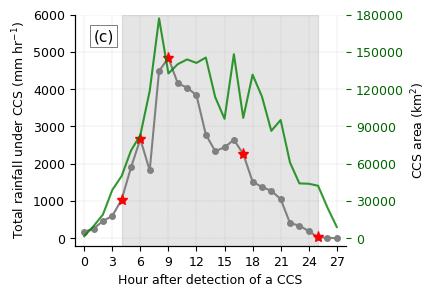

In [4]:
### 2. definition of MCS stages and variables in a track
out_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
data_track = xr.open_dataset(out_dir / 'mcs_tracks_non2mcs_2001.tropics30NS.extend.nc')

fig,ax = plt.subplots(1,1,figsize=(3.5,3))

track_id = 2000
ax2 = ax.twinx() # CCS area
#ax3 = ax.twinx() # MCS status
tot_rain = data_track.isel(tracks=track_id).total_rain
area = data_track.isel(tracks=track_id).ccs_area
avg_rain = tot_rain/area

# axis 1 
ax.plot(tot_rain,color='gray',marker='o',ms=4,zorder=1)
ax.set_ylabel('Total rainfall under CCS (mm hr$^{-1}$)', fontsize=9)

# axis 2
ax2.plot(area,color='g',zorder=1, alpha=0.8)
ax2.set_ylabel('CCS area (km$^{2}$)', fontsize=9, color='k')

# add MCS stages
idt_init = data_track.isel(tracks=track_id).idt_mcs_init
idt_grow = data_track.isel(tracks=track_id).idt_mcs_grow
idt_mature = data_track.isel(tracks=track_id).idt_mcs_mature
idt_decay = data_track.isel(tracks=track_id).idt_mcs_decay
idt_end = data_track.isel(tracks=track_id).idt_mcs_end

ax.plot(data_track.isel(tracks=track_id).idt_mcs_init, tot_rain.isel(times=idt_init), ms=8, marker='*', color='r', zorder=3)
ax.plot(data_track.isel(tracks=track_id).idt_mcs_grow, tot_rain.isel(times=idt_grow), ms=8, marker='*', color='r', zorder=3)
ax.plot(data_track.isel(tracks=track_id).idt_mcs_mature, tot_rain.isel(times=idt_mature), ms=8, marker='*', color='r', zorder=3)
ax.plot(data_track.isel(tracks=track_id).idt_mcs_decay, tot_rain.isel(times=idt_decay), ms=8, marker='*', color='r', zorder=3)
ax.plot(data_track.isel(tracks=track_id).idt_mcs_end, tot_rain.isel(times=idt_end), ms=8, marker='*', color='r', zorder=3)
# fill between MCS status
rec_mcs = Rectangle(xy=(idt_init.values, -200),width=(idt_end-idt_init).values, height=6200,
                    color='grey',alpha=0.2, zorder=-1)
ax.add_patch(rec_mcs)

ax.set_xlabel('Hour after detection of a CCS', fontsize=9)
ax.set_xlim([-1,28])
ax.set_xticks(np.arange(0,30,3))
ax2.set_yticks(np.arange(0,210000,30000))
ax.set_ylim([-200, 6000])
ax2.set_ylim([-6000, 180000])
ax.tick_params(labelsize=9)
ax2.tick_params(labelsize=9)
ax.grid(lw=0.2,ls=':',color='grey')

ax.text(x=1, y=5300, s='(c)', fontsize=11,
        bbox=dict(facecolor='w', alpha=0.7, edgecolor='k', pad=2.5, lw=0.5))

ax.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.tick_params(axis='y', colors='darkgreen')

plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig1_MCSstages_definition.pdf',
          bbox_inches='tight', transparent=False)

In [5]:
### 2. definition of MCS stages and variables in a track
out_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
data_track = xr.open_dataset(out_dir / 'mcs_tracks_non2mcs_2001.tropics30NS.extend.nc')

fig,ax = plt.subplots(1,1,figsize=(5,3))

track_id = 2000
ax2 = ax.twinx() # CCS area
#ax3 = ax.twinx() # MCS status
tot_rain = data_track.isel(tracks=track_id).total_rain
area = data_track.isel(tracks=track_id).ccs_area
avg_rain = tot_rain/area

# axis 1 
ax.plot(tot_rain,color='gray',marker='o',ms=4,zorder=1)
ax.set_ylabel('Total rainfall under CCS (mm hr$^{-1}$)', fontsize=9)

# axis 2
ax2.plot(area,color='g',zorder=1, alpha=0.8)
ax2.set_ylabel('CCS area (km$^{2}$)', fontsize=9, color='k')

# add MCS stages
idt_init = data_track.isel(tracks=track_id).idt_mcs_init
idt_grow = data_track.isel(tracks=track_id).idt_mcs_grow
idt_mature = data_track.isel(tracks=track_id).idt_mcs_mature
idt_decay = data_track.isel(tracks=track_id).idt_mcs_decay
idt_end = data_track.isel(tracks=track_id).idt_mcs_end

ax.plot(data_track.isel(tracks=track_id).idt_mcs_init, tot_rain.isel(times=idt_init), ms=8, marker='*', color='r', zorder=3)
ax.plot(data_track.isel(tracks=track_id).idt_mcs_grow, tot_rain.isel(times=idt_grow), ms=8, marker='*', color='r', zorder=3)
ax.plot(data_track.isel(tracks=track_id).idt_mcs_mature, tot_rain.isel(times=idt_mature), ms=8, marker='*', color='r', zorder=3)
ax.plot(data_track.isel(tracks=track_id).idt_mcs_decay, tot_rain.isel(times=idt_decay), ms=8, marker='*', color='r', zorder=3)
ax.plot(data_track.isel(tracks=track_id).idt_mcs_end, tot_rain.isel(times=idt_end), ms=8, marker='*', color='r', zorder=3)
# fill between MCS status
rec_mcs = Rectangle(xy=(idt_init.values, -200),width=(idt_end-idt_init).values, height=6200,
                    color='grey',alpha=0.2, zorder=-1)
ax.add_patch(rec_mcs)

ax.set_xlabel('Hour after the CCS detection', fontsize=9)
ax.set_xlim([-1,28])
ax.set_xticks(np.arange(0,30,3))
ax2.set_yticks(np.arange(0,210000,30000))
ax.set_ylim([-200, 6000])
ax2.set_ylim([-6000, 180000])
ax.tick_params(labelsize=9)
ax2.tick_params(labelsize=9)
ax.grid(lw=0.2,ls=':',color='grey')

#ax.text(x=1, y=5300, s='(c)', fontsize=11,
#        bbox=dict(facecolor='w', alpha=0.7, edgecolor='k', pad=2.5, lw=0.5))

ax.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.tick_params(axis='y', colors='darkgreen')

plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSstages_definition_4poster.pdf',
         bbox_inches='tight', transparent=False)

In [ ]:
### get B-P data of MCSs
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/BLtot_precip_hist/')
year_list = np.arange(2002,2021)

for n,year in enumerate(year_list):
    data = xr.open_dataset(out_dir / 'hist1d_BL_dtype.{}.ocean.3deg.alltracks.nc'.format(year))
    tmp = data.sum(('tracks','duration_type')).sel(bins_tot=slice(-29.75,10))
    
    if n == 0: 
        data_all_ocean = tmp
    else:
        data_all_ocean += tmp
        
for n,year in enumerate(year_list):
    data = xr.open_dataset(out_dir / 'hist1d_BL_dtype.{}.land.3deg.alltracks.nc'.format(year))
    tmp = data.sum(('tracks','duration_type')).sel(bins_tot=slice(-29.75,10))
    
    if n == 0: 
        data_all_land = tmp
    else:
        data_all_land += tmp
        
data_all_tot = data_all_ocean + data_all_land

In [ ]:
### 3. conditional precip done at each MCS stage
fig,ax = plt.subplots(1,1,figsize=(3.5,3))

ccolors = ['k','orange','r','limegreen','b']
set_width=0.2

for phase,ccolor in zip(data_all_ocean.phase.values[1:], ccolors):

    prec_gpm_phase = data_all_ocean.sel(area_type='mcs',phase=phase).prec_gpm_sum
    samples_phase = data_all_ocean.sel(area_type='mcs',phase=phase).samples
    prec_gpm_cond = prec_gpm_phase/samples_phase
    prec_gpm_cond = prec_gpm_cond.where(samples_phase > 200)

    ax.plot(data_all_ocean.bins_tot, prec_gpm_cond, '*',ms=5, color=ccolor,
            alpha=0.4, zorder=3) 

ax.set_xlabel('Buoyancy measure, B$_{L}$ (K)',fontsize=9.5)
ax.set_ylim([0,12])
ax.set_yticks(np.arange(0,14,2))
ax.set_ylabel('Precipitaiton rate (mm hr$^{-1}$)',fontsize=9.5)
ax.tick_params(labelsize=9)
ax.grid(lw=0.2,ls=':',color='grey')
ax.set_xlim([-30,5])

ax.text(x=-28, y=10.8, s='(d)', fontsize=11,
        bbox=dict(facecolor='w', alpha=0.7, edgecolor='k', pad=2.5, lw=0.5))
ax.legend(['Initial','Grow','Mature','Decay','End'],ncols=2,columnspacing=0
          ,bbox_to_anchor=(0.17,0.3,0.5,0.5)
          ,fontsize=9,frameon=True,edgecolor='grey')

# add reference of all grids
#ax.plot(data_all.BL_bins, cond_prec, 'o', color='grey', markeredgecolor='k', ls='None', ms=5, 
#        alpha=0.7)
# ax.plot(data_all_ocean.bins_tot, prec_gpm_cond_allphase, '--', color='k', lw=2,
#         alpha=0.7, zorder=3) 
ax.spines[['right', 'top']].set_visible(False)

plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig1_buoyPrec_MCSstages.pdf',
         bbox_inches='tight', transparent=False)

In [ ]:
# a revised fig 1a 